# Desafio de Previsão Industrial - Pipeline Ponta a Ponta

## 1. Configuração e Importações


In [2]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 5.0 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 5.7 MB/s eta 0:00:02
   --------------------- ------------------ 4.5/8.1 MB 6.5 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 6.6 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 6.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 6.5 MB/s  0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   --------------------------- ------------ 1.6/2.3 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 7.3 MB/s  0:00:00
Using ca

In [3]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost

  Using cached xgboost-3.1.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.2-py3-none-win_amd64.whl (72.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')


## 2. Carregamento dos Dados
Carregando os dados sintéticos dos sensores.


In [7]:
df = pd.read_csv("../Energia-IA/100k - Medidor 120/energia_202512091732-100k-120.csv", parse_dates=['data'], index_col='data')
df = df[['potencia_total_3_fases']].rename(columns={'potencia_total_3_fases': 'potencia_watts'})
print(df.head())
print(df.info())


                     potencia_watts
data                               
2025-12-09 17:31:26         1473.37
2025-12-09 17:30:51         1498.13
2025-12-09 17:30:17         1358.72
2025-12-09 17:29:42         1505.04
2025-12-09 17:29:08         1350.28
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2025-12-09 17:31:26 to 2025-10-30 07:29:32
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   potencia_watts  100000 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB
None


## 3. Pré-processamento
- Reamostragem para 15 minutos.
- Preenchimento de lacunas (gaps) usando interpolação linear.


In [8]:
# Reamostragem para 15min
df_resampled = df.resample('15min').mean()

# Preenchimento de Gaps (Interpolação)
df_resampled['potencia_watts'] = df_resampled['potencia_watts'].interpolate(method='linear')

print(f"Novo formato após reamostragem: {df_resampled.shape}")


Novo formato após reamostragem: (3882, 1)


## 4. Análise Exploratória de Dados (EDA)
Visualizando a série temporal, verificando estacionariedade e decompondo componentes.


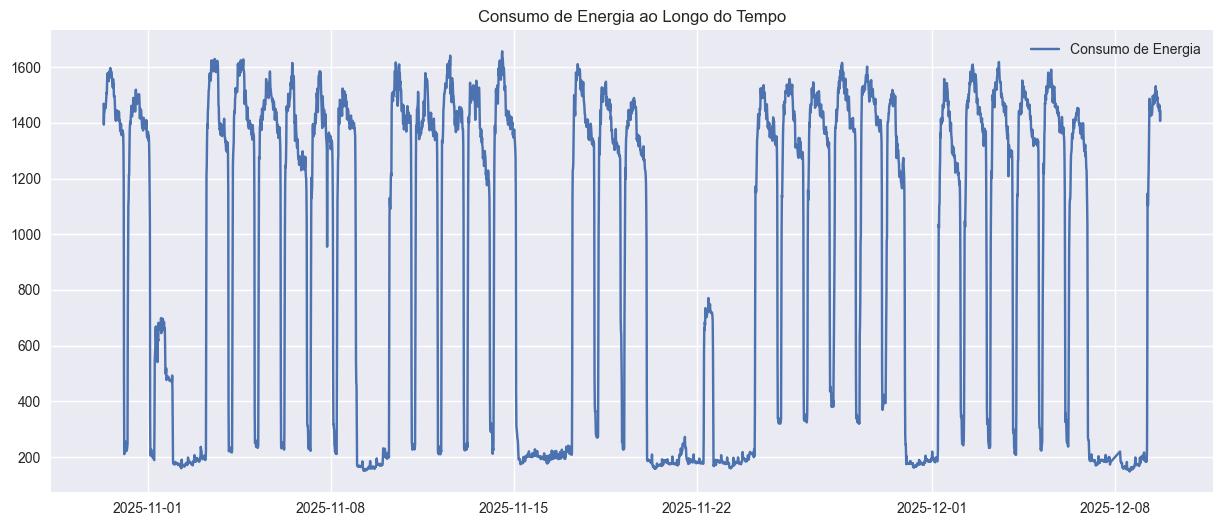

Estatística ADF: -5.556021308050009
p-valor: 1.580295238831978e-06
A série é estacionária.


In [9]:
# Gráfico da Série Temporal
plt.figure(figsize=(15, 6))
plt.plot(df_resampled.index, df_resampled['potencia_watts'], label='Consumo de Energia')
plt.title('Consumo de Energia ao Longo do Tempo')
plt.legend()
plt.show()

# Teste de Estacionariedade (ADF)
result = adfuller(df_resampled['potencia_watts'].dropna())
print(f'Estatística ADF: {result[0]}')
print(f'p-valor: {result[1]}')
if result[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série NÃO é estacionária.")


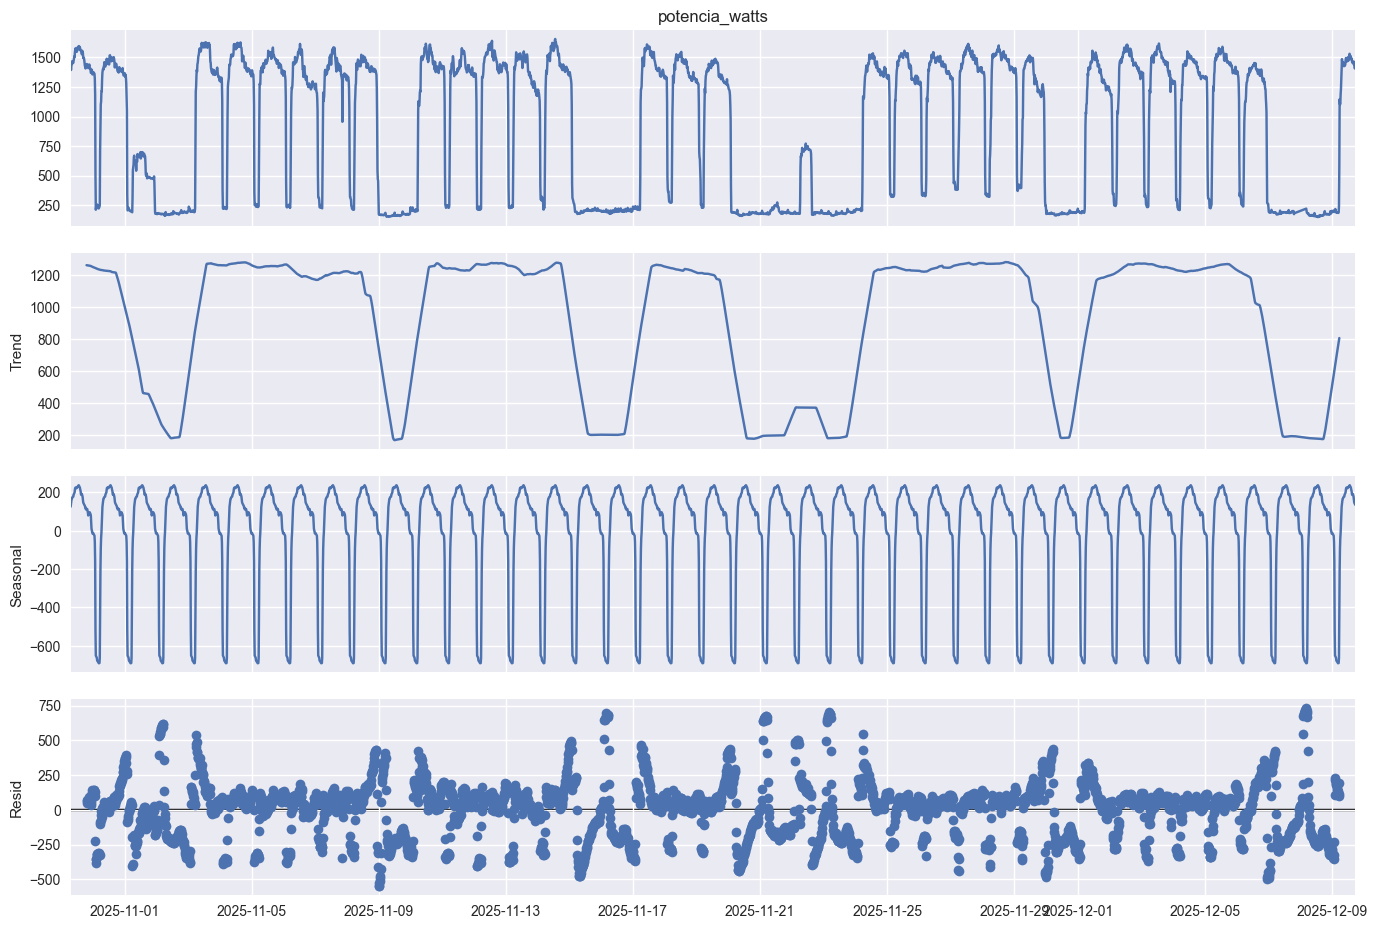

In [10]:
# Decomposição
decomposition = seasonal_decompose(df_resampled['potencia_watts'].dropna(), period=96) # 96 * 15min = 24h
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()


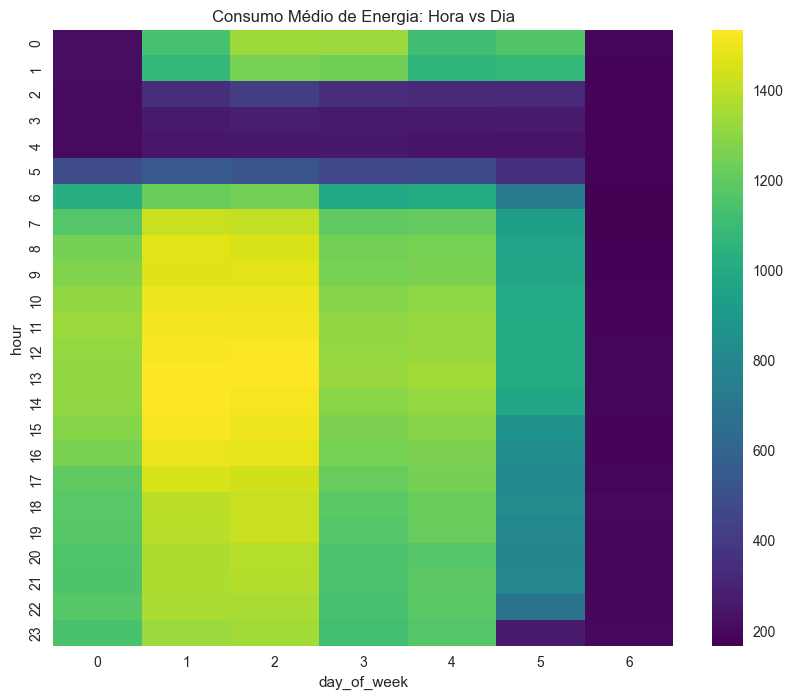

In [11]:
# Mapa de Calor (Dia vs Hora)
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
pivot_table = df_resampled.pivot_table(index='hour', columns='day_of_week', values='potencia_watts', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=False)
plt.title('Consumo Médio de Energia: Hora vs Dia')
plt.show()


## 5. Engenharia de Atributos (Feature Engineering)
Criando atributos cíclicos para tempo, defasagens (lags) e estatísticas móveis.


In [12]:
# Atributos Cíclicos
df_resampled['hour_sin'] = np.sin(2 * np.pi * df_resampled['hour'] / 24)
df_resampled['hour_cos'] = np.cos(2 * np.pi * df_resampled['hour'] / 24)
df_resampled['day_sin'] = np.sin(2 * np.pi * df_resampled['day_of_week'] / 7)
df_resampled['day_cos'] = np.cos(2 * np.pi * df_resampled['day_of_week'] / 7)

# Lags (Defasagens)
df_resampled['lag_1'] = df_resampled['potencia_watts'].shift(1)
df_resampled['lag_2'] = df_resampled['potencia_watts'].shift(2)
df_resampled['lag_24h'] = df_resampled['potencia_watts'].shift(96) # 24h * 4 (chunks de 15min)

# Estatísticas Móveis (Rolling stats)
df_resampled['rolling_mean'] = df_resampled['potencia_watts'].rolling(window=4).mean()
df_resampled['rolling_std'] = df_resampled['potencia_watts'].rolling(window=4).std()

df_model = df_resampled.dropna()
print(df_model.head())


                     potencia_watts  hour  day_of_week  hour_sin  hour_cos  \
data                                                                         
2025-10-31 07:15:00     1372.316800     7            4  0.965926 -0.258819   
2025-10-31 07:30:00     1393.748800     7            4  0.965926 -0.258819   
2025-10-31 07:45:00     1404.219231     7            4  0.965926 -0.258819   
2025-10-31 08:00:00     1396.089615     8            4  0.866025 -0.500000   
2025-10-31 08:15:00     1422.093077     8            4  0.866025 -0.500000   

                      day_sin   day_cos        lag_1        lag_2  \
data                                                                
2025-10-31 07:15:00 -0.433884 -0.900969  1312.795200  1213.230000   
2025-10-31 07:30:00 -0.433884 -0.900969  1372.316800  1312.795200   
2025-10-31 07:45:00 -0.433884 -0.900969  1393.748800  1372.316800   
2025-10-31 08:00:00 -0.433884 -0.900969  1404.219231  1393.748800   
2025-10-31 08:15:00 -0.433884 -0.900969

## 6. Modelagem
Comparando AutoARIMA (Estatístico) e XGBoost (Machine Learning).


In [13]:
# Divisão Treino/Teste
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size], df_model.iloc[train_size:]
print(f"Tamanho Treino: {len(train)}, Tamanho Teste: {len(test)}")


Tamanho Treino: 3028, Tamanho Teste: 758


Treinando AutoARIMA...
ARIMA RMSE: 658.8325127978561


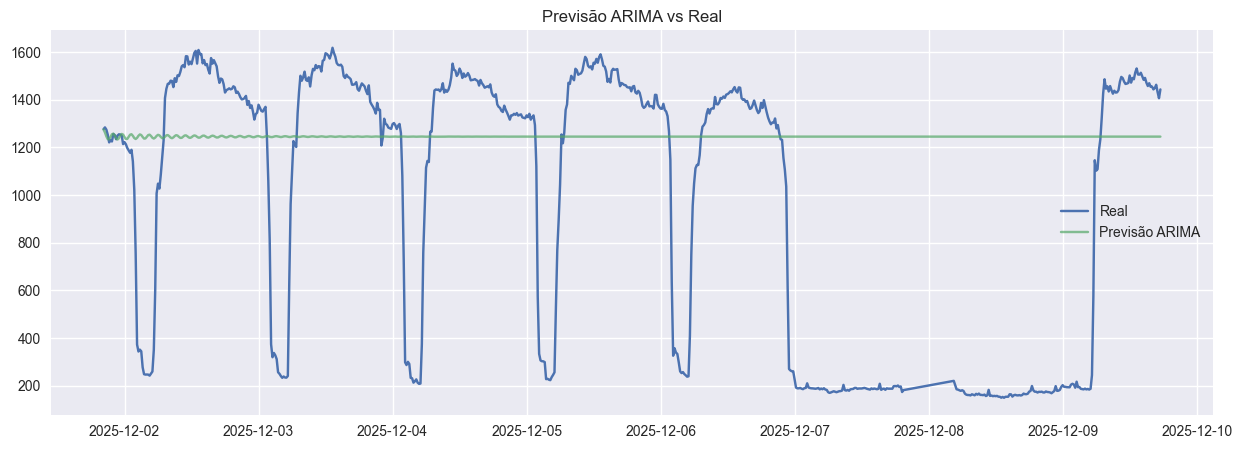

In [14]:
# Modelo 1: AutoARIMA
# Nota: ARIMA Sazonal pode ser lento. Usando parâmetros simplificados para demonstração.
print("Treinando AutoARIMA...")
model_arima = pm.auto_arima(train['potencia_watts'], seasonal=False, 
                            max_p=3, max_q=3, 
                            step_wise=True, suppress_warnings=True, error_action='ignore')

preds_arima = model_arima.predict(n_periods=len(test))
rmse_arima = np.sqrt(mean_squared_error(test['potencia_watts'], preds_arima))
print(f"ARIMA RMSE: {rmse_arima}")

# Plotar resultados ARIMA
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['potencia_watts'], label='Real')
plt.plot(test.index, preds_arima, label='Previsão ARIMA', alpha=0.7)
plt.legend()
plt.title('Previsão ARIMA vs Real')
plt.show()


Treinando XGBoost...
XGBoost RMSE: 26.686340870291673


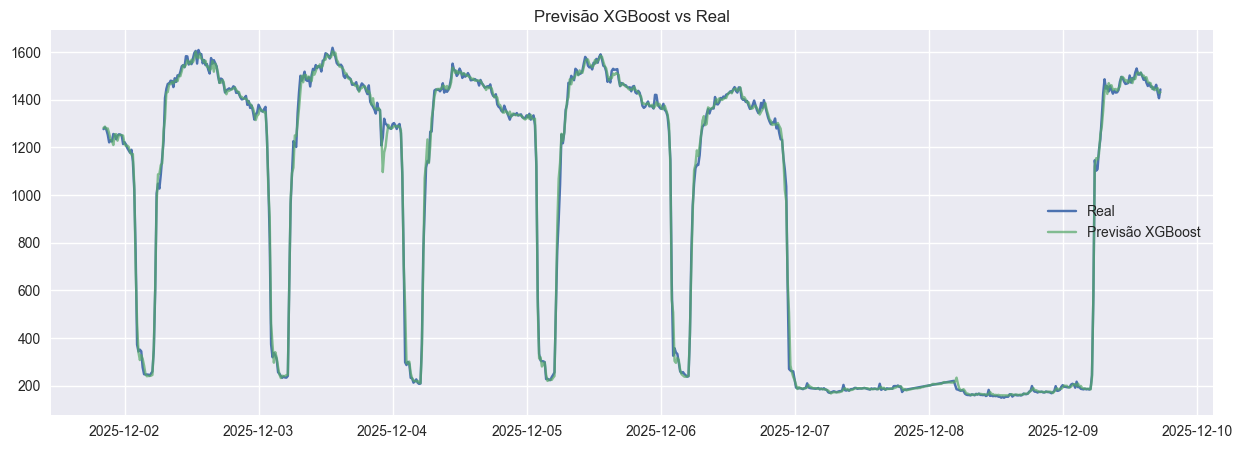

In [15]:
# Modelo 2: XGBoost
print("Treinando XGBoost...")
features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_24h', 'rolling_mean', 'rolling_std']
X_train, y_train = train[features], train['potencia_watts']
X_test, y_test = test[features], test['potencia_watts']

model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

# Plotar resultados XGBoost
plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Real')
plt.plot(test.index, preds_xgb, label='Previsão XGBoost', alpha=0.7)
plt.legend()
plt.title('Previsão XGBoost vs Real')
plt.show()


## 7. Conclusão
Comparação de desempenho dos modelos.


In [16]:
results = pd.DataFrame({
    'Modelo': ['AutoARIMA', 'XGBoost'],
    'RMSE': [rmse_arima, rmse_xgb]
})
print(results)

best_model = results.loc[results['RMSE'].idxmin()]
print(f"\nO melhor modelo é {best_model['Modelo']} com RMSE {best_model['RMSE']:.4f}")


      Modelo        RMSE
0  AutoARIMA  658.832513
1    XGBoost   26.686341

O melhor modelo é XGBoost com RMSE 26.6863
